## This notebook is "inspired" (ie mostly copied) from Cameron David Pilon's Screencast on [Predicting Ages from First Names](https://dataorigami.net/collections/statistics-and-probability/products/determining-ages-using-first-name-data) which walks through his package [demographica](https://github.com/CamDavidsonPilon/demographica). One thing the screencast doesn't do is walk through the data-wrangling, so I'll do that here.

* Dataset is from catalog.data.gov, specifically [Baby Names from Social Security Card Applications](https://catalog.data.gov/dataset/baby-names-from-social-security-card-applications-national-level-data)
* We're using the [Law of Total Probability](https://en.wikipedia.org/wiki/Law_of_total_probability) to determine the age distribution of customers by their first name. This is helped by the fact that names tend to go in and out of style. For example (granted, it is an extreme example), 70% of girls with the name "Brittany" are between 25 and 34 yrs old (as of April 27, 2020).
* The Law of Total Probability is defined as $$P( \text{Age bin} ) = \sum_{\text{name}} P( \text{Age bin}\;|\; \text{name} )P(\text{name}) $$ where:
    * P(name) is the probabilty of a given name (ie sum(quanity of people with name X) / sum(total quantity))
    * P(Age Bin | name) is the probability of an age bin given the name x (ie sum(quantity of name x in age bin z) / sum(quantity people with name x))
    * P(Age bin | name) P(name) = sum(quantity of quantity name x in bin) / sum(total quantity)


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from string import capwords
from datetime import date, datetime

In [2]:
pd.set_option('display.float_format', lambda x: '%.7f' % x)
file_path = './data/ssa_names'
columns=['name', 'gender', 'quantity']
df_columns=['name', 'gender', 'quantity']
df = pd.DataFrame(columns=df_columns)
counter = 0 # this is just used to limit the data import loop for testing
year_ = date.today().year
max_age = 84 # Since data goes back to 1880, and I doubt there are many 140 yr olds making online purchases, this variable is used to filter the data for ages we want to exclude.

In [3]:
def age_binner(age):
    if age < 5:
        return "04 and under"
    elif 5 <= age <= 9:
        return "05 to 09 years" 
    elif 10 <= age <= 14:
        return "10 to 14 years" 
    elif 15 <= age <= 19:
        return "15 to 19 years" 
    elif 20 <= age <= 24:
        return "20 to 24 years" 
    elif 25 <= age <= 29:
        return "25 to 29 years" 
    elif 30 <= age <= 34:
        return "30 to 34 years" 
    elif 35 <= age <= 39:
        return "35 to 39 years" 
    elif 40 <= age <= 44:
        return "40 to 44 years" 
    elif 45 <= age <= 49:
        return "45 to 49 years" 
    elif 50 <= age <= 54:
        return "50 to 54 years" 
    elif 55 <= age <= 59:
        return "55 to 59 years" 
    elif 60 <= age <= 64:
        return "60 to 64 years" 
    elif 65 <= age <= 69:
        return "65 to 69 years" 
    elif 70 <= age <= 74:
        return "70 to 74 years" 
    elif 75 <= age <=79:
        return "75 to 79 years" 
    elif 80 <= age <=84:
        return "80 to 84 years" 
    else:
        return "85 years and over"



# Import data from ssa names_by_year

In [4]:
for (path, dirs, files) in os.walk(file_path):
    for file in files:
        # if counter < 3:
        if file.endswith('.txt'):
            try:
                yob = file.replace('yob','').replace('.txt','')
                file_path = path +'/'+file
                data = pd.read_csv(file_path, header=None, names=columns)
                data['yob'] = datetime.strptime(yob, '%Y').__format__('%Y')
                data['age'] = year_ - datetime.strptime(yob, '%Y').year
                df = pd.concat([df, data], sort=False) 
                # counter += 1
            except:
                print('File: ', file)
                print("Unexpected error:", sys.exc_info()[0])
#             counter += 1

In [5]:
df.head()

,name,gender,quantity,yob,age
0,Emily,F,25956,2000,20.0000000
1,Hannah,F,23082,2000,20.0000000
2,Madison,F,19968,2000,20.0000000
3,Ashley,F,17997,2000,20.0000000
4,Sarah,F,17702,2000,20.0000000


In [6]:
# remove unwanted data from dataframe based on customer age
df = df[df['age'] <= max_age]

In [7]:
# %%timeit
df['age_bin'] = df['age'].map(age_binner)
total_people = df['quantity'].sum()

## Get distribution by age bins

In [8]:
US_AGE_DIST = df.groupby(['age_bin'])['quantity'].sum().reset_index()
US_AGE_DIST['percentage'] = US_AGE_DIST['quantity']/total_people
US_AGE_DIST.drop(['quantity'], axis=1, inplace=True)
US_AGE_DIST.set_index('age_bin')

,percentage
age_bin,
04 and under,0.0367703
05 to 09 years,0.0629678
10 to 14 years,0.0665685
15 to 19 years,0.0650442
20 to 24 years,0.0632588
25 to 29 years,0.0648466
30 to 34 years,0.0640470
35 to 39 years,0.0600541
40 to 44 years,0.0554914


## Calculate P(Age bin | name)
1. Group by name and age bin
2. Get totals for each name
3. Get probabilities for names by age bins
4. Add multidimensional index of name, age_bin

In [9]:
#1
name_distro = df.groupby(['name', 'age_bin'])['quantity'].sum().reset_index()

#2
name_totals = name_distro.groupby('name')['quantity'].sum()

#3
name_distro['name_total'] = name_distro['name'].map(name_totals)
name_distro['name_percentage'] = name_distro['quantity'] / name_distro['name_total']

#4 Set a multiindex of name, age_bin
name_distro = name_distro.drop(['quantity', 'name_total'], axis=1).set_index(['name', 'age_bin'])
# Since not all names have all the bins, this is a neat little trick that fills in the missing bins
NAME_DIST = name_distro.unstack('age_bin', fill_value=0).stack(level=1)
# Create a set of names from the NAME_DIST dataframe
VALID_NAMES = set(NAME_DIST.index.levels[0])

In [10]:
def get_name_distro(name, df):
    return df.loc[name]
    # return df[df.name == name]

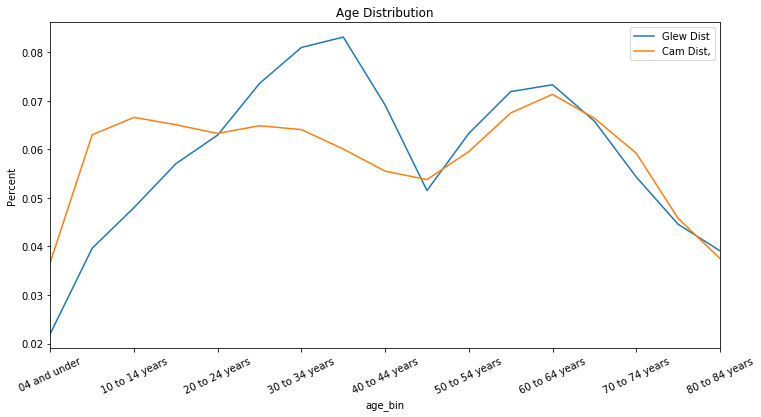

In [11]:
name = 'Elizabeth'
plt.figure(figsize=(12,6))
ax = plt.gca()
ax.set_ylabel('Percent')
ax.set_xlabel('Age')
ax.set_title('Age Distribution')
get_name_distro(name, NAME_DIST).plot(kind='line',ax=ax, rot=25)
US_AGE_DIST.plot(kind='line',ax=ax, rot=25)
ax.legend(['Glew Dist','Cam Dist,','US Dist'])

## Calculate P(name). NOTE: P(name) is the probability of the name in the list you're analyzing, NOT the probability of the name in the general population

In [12]:
def calculate_name_probability(names):
    data = pd.Series(names).map(capwords)
    data = data.loc[data.map(lambda n: n in VALID_NAMES)]
    normalized_data = data.groupby(data.values).count()/data.shape[0]
    return normalized_data

In [15]:
first_names = pd.read_csv('./data/first_names.csv')
first_names.head()

,first_name
0,Elizabeth
1,Charles
2,Ben
3,Olga
4,Timothy


In [19]:
name_dist = calculate_name_probability(first_names['first_name'])
name_dist.sort_values()

Kane      0.0002431
Liliya    0.0002431
Lillian   0.0002431
Lincoln   0.0002431
Lionel    0.0002431
             ...   
Chris     0.0094821
Brian     0.0097253
John      0.0102115
David     0.0143448
Michael   0.0192074
Name: first_name, Length: 1378, dtype: float64

In [20]:
def age_calculator(name_frequencies):
    prob = 0.
    for name, freq in name_frequencies.iteritems():
        try:
            prob += NAME_DIST.loc[name] * freq
        except:
            print("Error")
            pass
    return prob

In [21]:
age_dist = age_calculator(name_dist)
age_dist

,name_percentage
age_bin,
04 and under,0.0246007
05 to 09 years,0.0434533
10 to 14 years,0.0508396
15 to 19 years,0.0553958
20 to 24 years,0.0595386
25 to 29 years,0.0689741
30 to 34 years,0.0753574
35 to 39 years,0.0740250
40 to 44 years,0.0696012


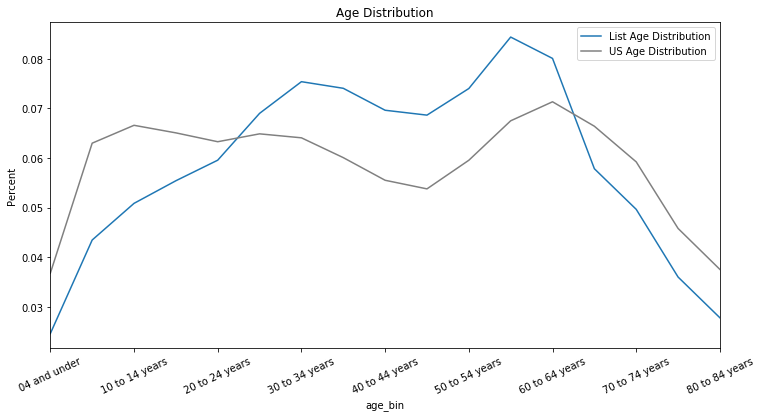

In [29]:
plt.figure(figsize=(12,6))
ax = plt.gca()
ax.set_ylabel('Percent')
ax.set_xlabel('Age')
ax.set_title('Age Distribution')
age_dist.plot(kind='line',ax=ax, rot=25)
US_AGE_DIST.plot(kind='line',ax=ax, color='grey', rot=25,)
ax.legend(['List Age Distribution','US Age Distribution'])